# Bankroll Simulation

In [13]:
import json
import os
import random
import statistics

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from src import *

TOTAL_SIMULATIONS = 1000
SEED = 42
SIMULATION_DIR = "simulations-data"
SIMULATION_NAME = "Month Baccarat"
ESPECIF_SIMULATION_VIEW = 3

## 1. Generate Simulations

In [14]:
if os.path.exists(SIMULATION_DIR):
    print(f"Directory '{SIMULATION_DIR}' already exists. Skipping simulation generation.")
    print(f"Delete the directory to regenerate.")
else:
    os.makedirs(SIMULATION_DIR)
    random.seed(SEED)
    for i in range(TOTAL_SIMULATIONS):
        result = play_simulation(
            "config/simulations", "config/sessions", "config/games", SIMULATION_NAME
        )
        filepath = os.path.join(SIMULATION_DIR, f"{SIMULATION_NAME}_{i}.json")
        with open(filepath, "w") as f:
            json.dump(result, f)
        if (i + 1) % 10000 == 0:
            print(f"Generated {i + 1}/{TOTAL_SIMULATIONS} simulations")
    print(f"Done. All {TOTAL_SIMULATIONS} simulations saved to '{SIMULATION_DIR}/'.")

Done. All 1000 simulations saved to 'simulations-data/'.


## 2. Game Expected Values

In [15]:
all_evs = get_all_games_ev("config/games")

for game_name, ev_data in all_evs.items():
    if "bet-types" in ev_data:
        print(f"{ev_data['name']}:")
        for bt, ev_val in ev_data["bet-types"].items():
            print(f"  {bt}: EV = {ev_val:+.6f}")
    else:
        print(f"{ev_data['name']}: EV = {ev_data['ev']:+.6f}")

Sit & Go 9 Players: EV = -0.190000
Multi-Table Tournament: EV = -0.030700
Baccarat:
  player: EV = -0.107600
  banker: EV = -0.010530
  tie: EV = -0.143200
Slots: EV = +3.800000


## 3. Average Simulation Results

In [16]:
# Load all simulations
simulations = []
for i in range(TOTAL_SIMULATIONS):
    filepath = os.path.join(SIMULATION_DIR, f"{SIMULATION_NAME}_{i}.json")
    with open(filepath, "r") as f:
        simulations.append(json.load(f))

print(f"Loaded {len(simulations)} simulations.")

Loaded 1000 simulations.


In [17]:
def extract_bankroll_curve(simulation):
    """Extract the bankroll value after each action in a simulation."""
    curve = []
    for action in simulation:
        if action["type"] == "play" and action["bets"]:
            for bet in action["bets"]:
                curve.append(bet["bankroll"])
        else:
            curve.append(action["bankroll"])
    return curve


def get_start_bankroll(simulation):
    """Get the starting bankroll from the first action."""
    first = simulation[0]
    if first["type"] == "play" and first["bets"]:
        return first["bets"][0]["bankroll"] + first["bets"][0]["bet-size"] - first["bets"][0]["payment"]
    return first["bankroll"]


def get_final_bankroll(simulation):
    """Get the final bankroll from the last action."""
    return simulation[-1]["bankroll"]

In [18]:
start_bankroll = get_start_bankroll(simulations[0])

final_bankrolls = [get_final_bankroll(sim) for sim in simulations]
profits = [fb - start_bankroll for fb in final_bankrolls]

wins = [p for p in profits if p > 0]
losses = [p for p in profits if p < 0]
breakevens = [p for p in profits if p == 0]
bankrupt_count = sum(1 for fb in final_bankrolls if fb <= 0)

min_bankrolls = []
max_bankrolls = []
for sim in simulations:
    curve = extract_bankroll_curve(sim)
    if curve:
        min_bankrolls.append(min(curve))
        max_bankrolls.append(max(curve))

print(f"{'='*55}")
print(f"  SIMULATION SUMMARY ({TOTAL_SIMULATIONS:,} runs)")
print(f"{'='*55}")
print(f"  Starting bankroll:        {start_bankroll:>12,.2f}")
print(f"  Average final bankroll:   {statistics.mean(final_bankrolls):>12,.2f}")
print(f"  Median final bankroll:    {statistics.median(final_bankrolls):>12,.2f}")
print(f"  Std dev final bankroll:   {statistics.stdev(final_bankrolls):>12,.2f}")
print(f"{'-'*55}")
print(f"  Average profit:           {statistics.mean(profits):>+12,.2f}")
print(f"  Median profit:            {statistics.median(profits):>+12,.2f}")
print(f"  Average win (when > 0):   {statistics.mean(wins):>+12,.2f}" if wins else "  No winning simulations")
print(f"  Average loss (when < 0):  {statistics.mean(losses):>+12,.2f}" if losses else "  No losing simulations")
print(f"{'-'*55}")
print(f"  Profitable simulations:   {len(wins):>8,} ({100*len(wins)/TOTAL_SIMULATIONS:.2f}%)")
print(f"  Losing simulations:       {len(losses):>8,} ({100*len(losses)/TOTAL_SIMULATIONS:.2f}%)")
print(f"  Break-even simulations:   {len(breakevens):>8,} ({100*len(breakevens)/TOTAL_SIMULATIONS:.2f}%)")
print(f"  Bankrupt (bankroll <= 0): {bankrupt_count:>8,} ({100*bankrupt_count/TOTAL_SIMULATIONS:.2f}%)")
print(f"{'-'*55}")
print(f"  Min bankroll (overall):   {min(min_bankrolls):>12,.2f}")
print(f"  Max bankroll (overall):   {max(max_bankrolls):>12,.2f}")
print(f"  Avg min bankroll:         {statistics.mean(min_bankrolls):>12,.2f}")
print(f"  Avg max bankroll:         {statistics.mean(max_bankrolls):>12,.2f}")
print(f"  Max profit:               {max(profits):>+12,.2f}")
print(f"  Max loss:                 {min(profits):>+12,.2f}")
print(f"{'='*55}")

  SIMULATION SUMMARY (1,000 runs)
  Starting bankroll:            1,000.00
  Average final bankroll:         916.27
  Median final bankroll:          870.00
  Std dev final bankroll:         527.17
-------------------------------------------------------
  Average profit:                 -83.73
  Median profit:                 -130.00
  Average win (when > 0):        +410.94
  Average loss (when < 0):       -453.87
-------------------------------------------------------
  Profitable simulations:        428 (42.80%)
  Losing simulations:            572 (57.20%)
  Break-even simulations:          0 (0.00%)
  Bankrupt (bankroll <= 0):        0 (0.00%)
-------------------------------------------------------
  Min bankroll (overall):           5.00
  Max bankroll (overall):       3,045.00
  Avg min bankroll:               581.79
  Avg max bankroll:             1,382.70
  Max profit:                  +2,045.00
  Max loss:                      -995.00


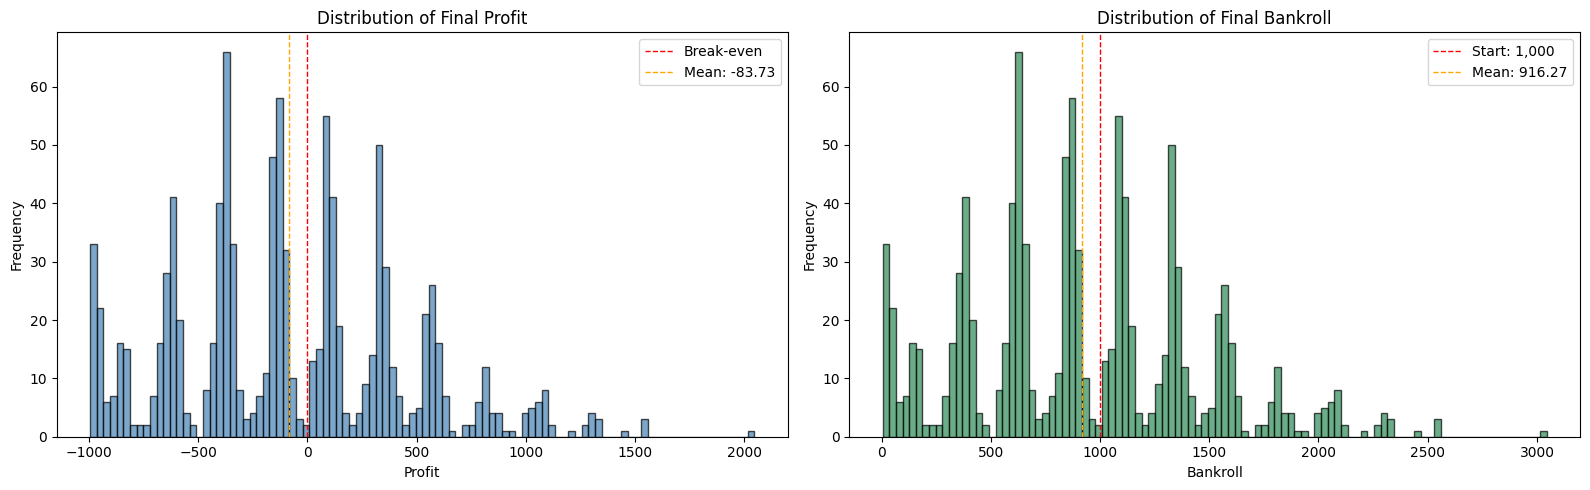

In [19]:
# Distribution of final profits
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(profits, bins=100, edgecolor="black", alpha=0.7, color="steelblue")
axes[0].axvline(0, color="red", linestyle="--", linewidth=1, label="Break-even")
axes[0].axvline(statistics.mean(profits), color="orange", linestyle="--", linewidth=1, label=f"Mean: {statistics.mean(profits):+,.2f}")
axes[0].set_title("Distribution of Final Profit")
axes[0].set_xlabel("Profit")
axes[0].set_ylabel("Frequency")
axes[0].legend()

axes[1].hist(final_bankrolls, bins=100, edgecolor="black", alpha=0.7, color="seagreen")
axes[1].axvline(start_bankroll, color="red", linestyle="--", linewidth=1, label=f"Start: {start_bankroll:,.0f}")
axes[1].axvline(statistics.mean(final_bankrolls), color="orange", linestyle="--", linewidth=1, label=f"Mean: {statistics.mean(final_bankrolls):,.2f}")
axes[1].set_title("Distribution of Final Bankroll")
axes[1].set_xlabel("Bankroll")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

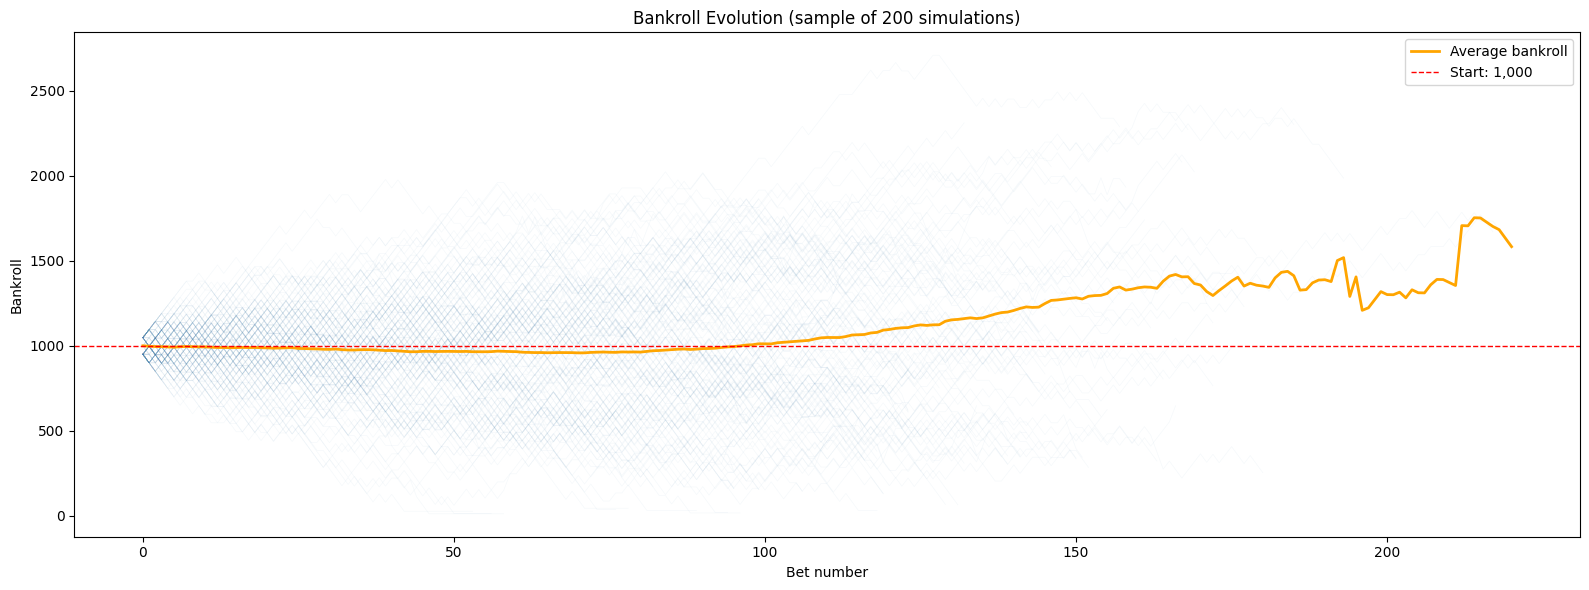

In [20]:
# Bankroll evolution: sample of simulations
SAMPLE_SIZE = 200
sample_indices = random.sample(range(TOTAL_SIMULATIONS), min(SAMPLE_SIZE, TOTAL_SIMULATIONS))

fig, ax = plt.subplots(figsize=(16, 6))
for idx in sample_indices:
    curve = extract_bankroll_curve(simulations[idx])
    ax.plot(curve, alpha=0.05, color="steelblue", linewidth=0.5)

# Compute and plot the average curve
all_curves = [extract_bankroll_curve(sim) for sim in simulations]
max_len = max(len(c) for c in all_curves)
avg_curve = []
for step in range(max_len):
    values = [c[step] for c in all_curves if step < len(c)]
    avg_curve.append(statistics.mean(values))

ax.plot(avg_curve, color="orange", linewidth=2, label="Average bankroll")
ax.axhline(start_bankroll, color="red", linestyle="--", linewidth=1, label=f"Start: {start_bankroll:,.0f}")
ax.set_title(f"Bankroll Evolution (sample of {len(sample_indices)} simulations)")
ax.set_xlabel("Bet number")
ax.set_ylabel("Bankroll")
ax.legend()
plt.tight_layout()
plt.show()

## 4. Key Simulations: Worst, Best, and Average

In [21]:
worst_idx = profits.index(min(profits))
best_idx = profits.index(max(profits))

# Find simulation closest to the mean profit
mean_profit = statistics.mean(profits)
avg_idx = min(range(TOTAL_SIMULATIONS), key=lambda i: abs(profits[i] - mean_profit))

print(f"Worst simulation: #{worst_idx}  (profit: {profits[worst_idx]:+,.2f}, final bankroll: {final_bankrolls[worst_idx]:,.2f})")
print(f"Best simulation:  #{best_idx}  (profit: {profits[best_idx]:+,.2f}, final bankroll: {final_bankrolls[best_idx]:,.2f})")
print(f"Avg simulation:   #{avg_idx}  (profit: {profits[avg_idx]:+,.2f}, final bankroll: {final_bankrolls[avg_idx]:,.2f})")

Worst simulation: #873  (profit: -995.00, final bankroll: 5.00)
Best simulation:  #453  (profit: +2,045.00, final bankroll: 3,045.00)
Avg simulation:   #263  (profit: -82.50, final bankroll: 917.50)


In [22]:
def plot_simulation(sim, sim_idx, title, color):
    curve = extract_bankroll_curve(sim)
    final = get_final_bankroll(sim)
    profit = final - start_bankroll

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Bankroll evolution
    axes[0].plot(curve, color=color, linewidth=1)
    axes[0].axhline(start_bankroll, color="red", linestyle="--", linewidth=1, label=f"Start: {start_bankroll:,.0f}")
    axes[0].set_title(f"{title} (Simulation #{sim_idx})")
    axes[0].set_xlabel("Bet number")
    axes[0].set_ylabel("Bankroll")
    axes[0].legend()

    # Bet result distribution
    results = []
    for action in sim:
        if action["type"] == "play":
            for bet in action["bets"]:
                net = bet["payment"] - bet["bet-size"]
                results.append(net)
    if results:
        axes[1].hist(results, bins=30, edgecolor="black", alpha=0.7, color=color)
        axes[1].axvline(0, color="red", linestyle="--", linewidth=1)
        axes[1].set_title(f"Bet Results Distribution (#{sim_idx})")
        axes[1].set_xlabel("Net result per bet")
        axes[1].set_ylabel("Frequency")
    else:
        axes[1].text(0.5, 0.5, "No bets placed", ha="center", va="center", transform=axes[1].transAxes)

    fig.suptitle(f"Profit: {profit:+,.2f} | Final bankroll: {final:,.2f}", fontsize=10, y=1.02)
    plt.tight_layout()
    plt.show()

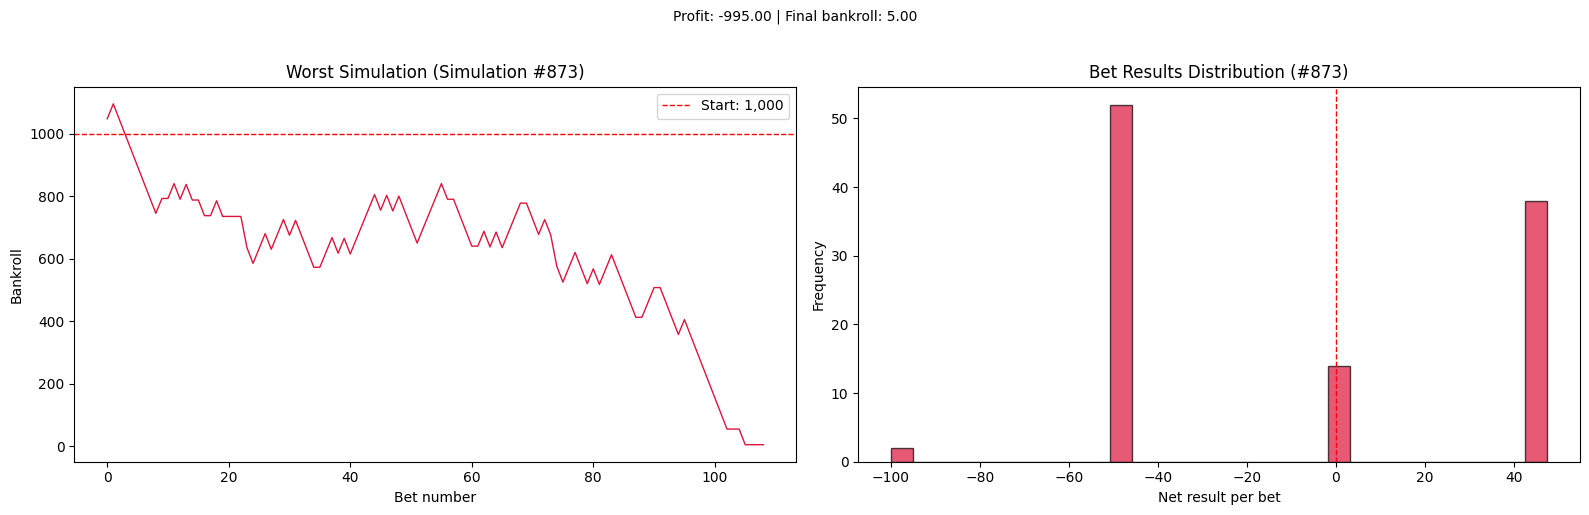

In [23]:
plot_simulation(simulations[worst_idx], worst_idx, "Worst Simulation", "crimson")

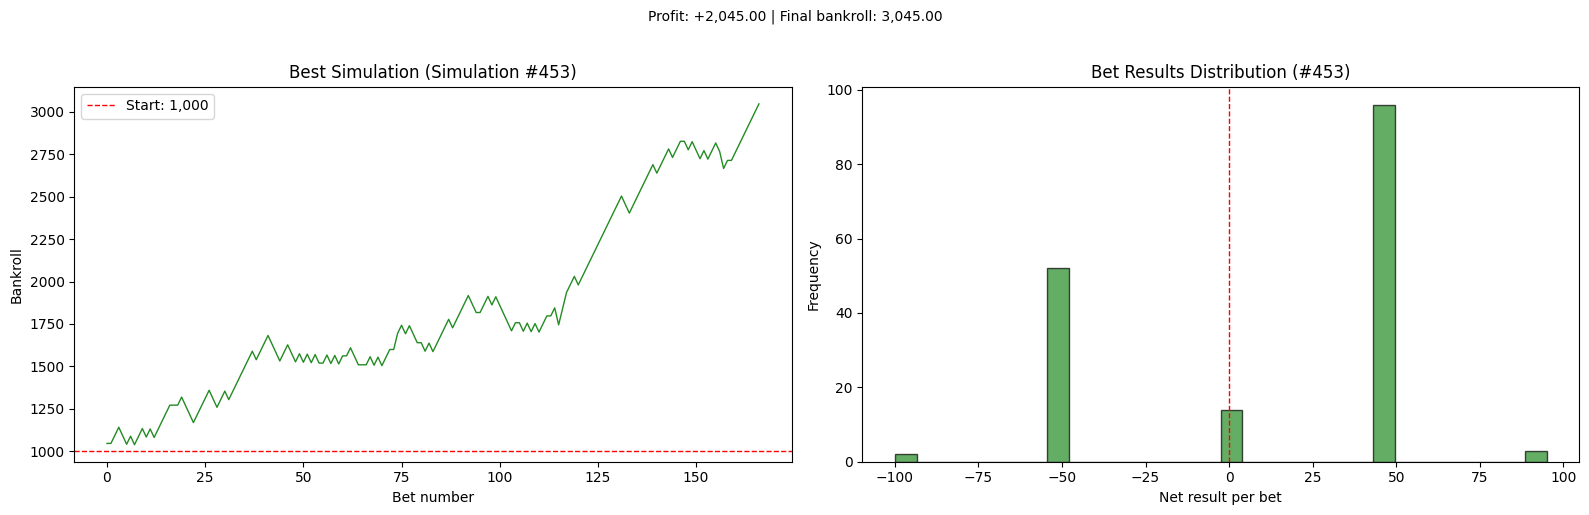

In [24]:
plot_simulation(simulations[best_idx], best_idx, "Best Simulation", "forestgreen")

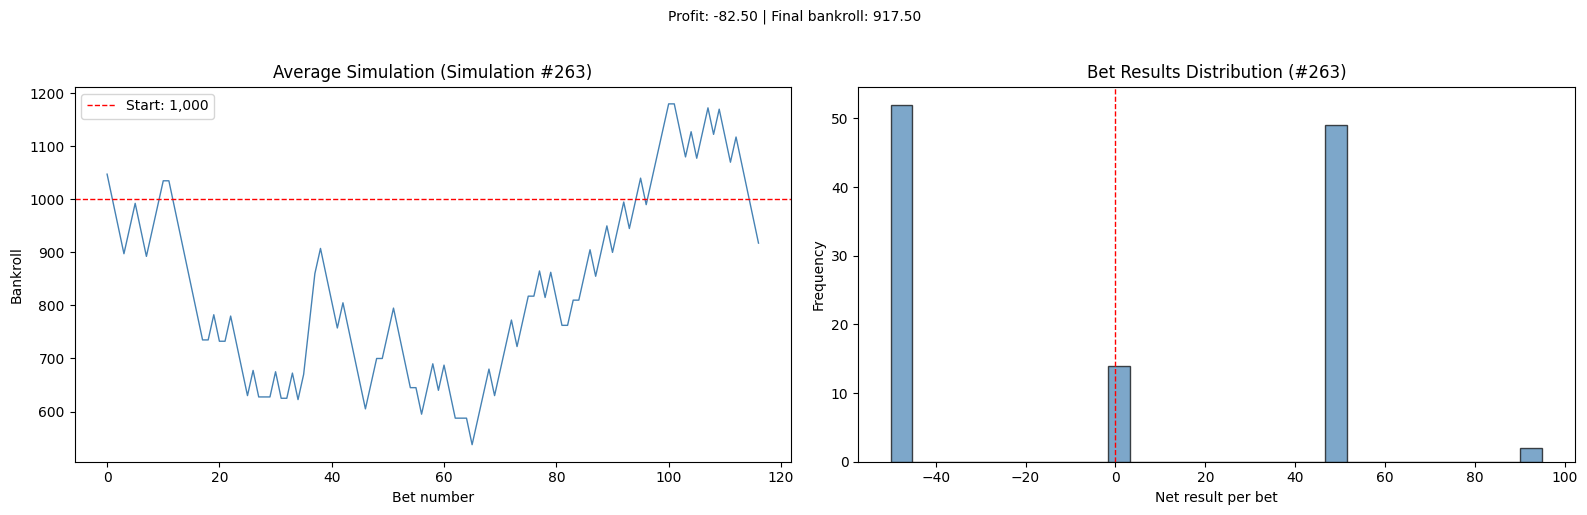

In [25]:
plot_simulation(simulations[avg_idx], avg_idx, "Average Simulation", "steelblue")

## 5. Specific Simulation View

In [26]:
print(f"Viewing simulation #{ESPECIF_SIMULATION_VIEW}")
print(f"{'='*55}")

spec_sim = simulations[ESPECIF_SIMULATION_VIEW]
spec_final = get_final_bankroll(spec_sim)
spec_profit = spec_final - start_bankroll
spec_curve = extract_bankroll_curve(spec_sim)

total_bets = sum(len(a["bets"]) for a in spec_sim if a["type"] == "play")
total_sessions = sum(1 for a in spec_sim if a["type"] == "play")

print(f"  Starting bankroll: {start_bankroll:>12,.2f}")
print(f"  Final bankroll:    {spec_final:>12,.2f}")
print(f"  Profit:            {spec_profit:>+12,.2f}")
print(f"  Total sessions:    {total_sessions:>12,}")
print(f"  Total bets:        {total_bets:>12,}")
if spec_curve:
    print(f"  Min bankroll:      {min(spec_curve):>12,.2f}")
    print(f"  Max bankroll:      {max(spec_curve):>12,.2f}")
print(f"{'='*55}")

print(f"\nActions:")
for i, action in enumerate(spec_sim):
    if action["type"] == "play":
        n_bets = len(action["bets"])
        print(f"  [{i+1}] Play '{action['name']}' - {n_bets} bets - bankroll: {action['bankroll']:,.2f}")
    elif action["type"] == "withdraw":
        print(f"  [{i+1}] Withdraw {action['size']:,.2f} - bankroll: {action['bankroll']:,.2f}")
    elif action["type"] == "aport":
        print(f"  [{i+1}] Deposit {action['size']:,.2f} - bankroll: {action['bankroll']:,.2f}")

Viewing simulation #3
  Starting bankroll:     1,000.00
  Final bankroll:          385.00
  Profit:                 -615.00
  Total sessions:              30
  Total bets:                 114
  Min bankroll:             60.00
  Max bankroll:          1,095.00

Actions:
  [1] Play 'Avarage Baccarat' - 7 bets - bankroll: 945.00
  [2] Play 'Avarage Baccarat' - 1 bets - bankroll: 895.00
  [3] Play 'Avarage Baccarat' - 2 bets - bankroll: 845.00
  [4] Play 'Avarage Baccarat' - 1 bets - bankroll: 795.00
  [5] Play 'Avarage Baccarat' - 6 bets - bankroll: 982.50
  [6] Play 'Avarage Baccarat' - 5 bets - bankroll: 927.50
  [7] Play 'Avarage Baccarat' - 1 bets - bankroll: 877.50
  [8] Play 'Avarage Baccarat' - 6 bets - bankroll: 822.50
  [9] Play 'Avarage Baccarat' - 12 bets - bankroll: 1,005.00
  [10] Play 'Avarage Baccarat' - 1 bets - bankroll: 955.00
  [11] Play 'Avarage Baccarat' - 1 bets - bankroll: 905.00
  [12] Play 'Avarage Baccarat' - 1 bets - bankroll: 855.00
  [13] Play 'Avarage Baccara

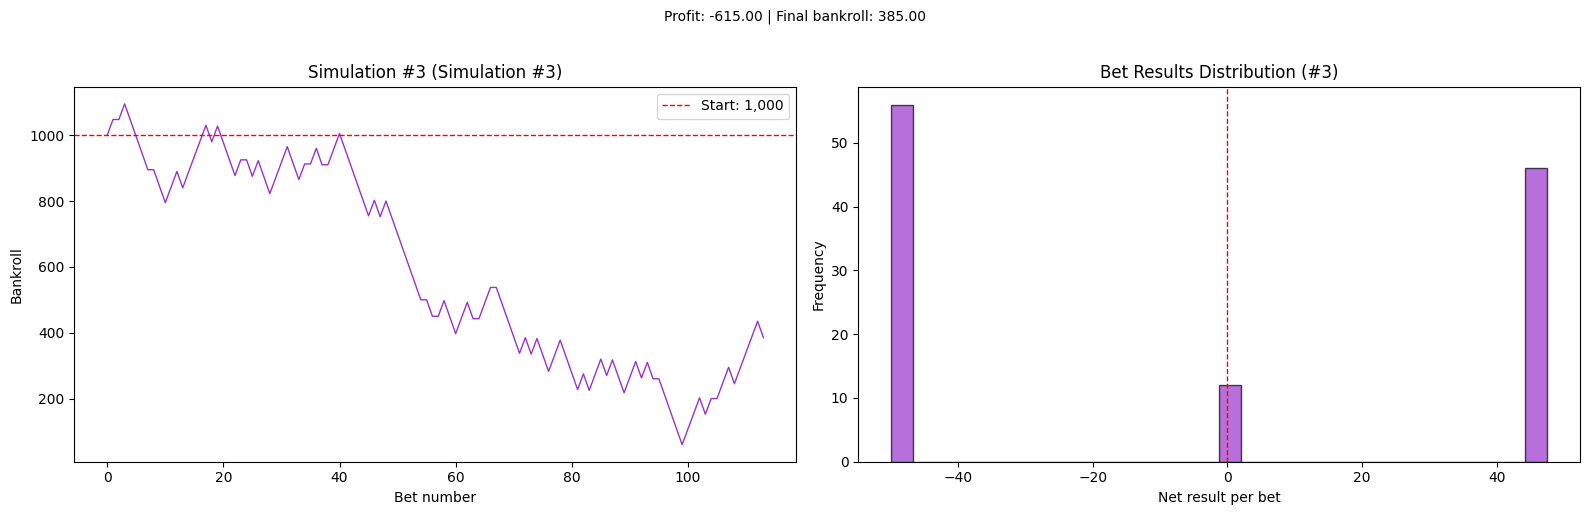

In [27]:
plot_simulation(spec_sim, ESPECIF_SIMULATION_VIEW, f"Simulation #{ESPECIF_SIMULATION_VIEW}", "darkorchid")

## 6. Risk Profile — Percentage Outcomes

In [ ]:
# Compute percentage change for each simulation
profit_pcts = [(p / start_bankroll) * 100 for p in profits]
profit_pcts_sorted = sorted(profit_pcts)

# --- Percentile summary ---
percentiles = [5, 10, 25, 50, 75, 90, 95]
print(f"{'='*50}")
print(f"  RISK PERCENTILES ({TOTAL_SIMULATIONS:,} simulations)")
print(f"{'='*50}")
for pct in percentiles:
    idx = int(len(profit_pcts_sorted) * pct / 100)
    idx = min(idx, len(profit_pcts_sorted) - 1)
    val = profit_pcts_sorted[idx]
    print(f"  {pct:3d}th percentile:  bankroll changed {val:+.1f}%")
print(f"{'='*50}")

In [ ]:
# --- Outcome bucket bar chart ---
# Define percentage buckets from worst to best
bucket_edges = [-float("inf"), -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, float("inf")]
bucket_labels = [
    "Lost >80%", "Lost 60-80%", "Lost 40-60%", "Lost 20-40%", "Lost 0-20%",
    "Gained 0-20%", "Gained 20-40%", "Gained 40-60%", "Gained 60-80%",
    "Gained 80-100%", "Gained >100%",
]
bucket_colors = [
    "#67000d", "#a50f15", "#cb181d", "#ef3b2c", "#fb6a4a",
    "#a1d99b", "#74c476", "#41ab5d", "#238b45", "#006d2c", "#00441b",
]

bucket_counts = [0] * len(bucket_labels)
for pct in profit_pcts:
    for i in range(len(bucket_edges) - 1):
        if bucket_edges[i] <= pct < bucket_edges[i + 1]:
            bucket_counts[i] += 1
            break

bucket_pcts = [c / TOTAL_SIMULATIONS * 100 for c in bucket_counts]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(bucket_labels, bucket_pcts, color=bucket_colors, edgecolor="black", linewidth=0.5)

for bar, pct_val, count in zip(bars, bucket_pcts, bucket_counts):
    if pct_val > 0:
        ax.text(
            bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
            f"{pct_val:.1f}% ({count})",
            va="center", fontsize=9,
        )

ax.set_xlabel("% of simulations")
ax.set_title("Bankroll Outcome Distribution")
ax.set_xlim(0, max(bucket_pcts) * 1.3)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# --- Cumulative probability curve ---
# "What is the probability of achieving at least X% return?"
fig, ax = plt.subplots(figsize=(14, 6))

# Survival function: P(profit% >= x)
x_vals = profit_pcts_sorted
y_vals = [(TOTAL_SIMULATIONS - i) / TOTAL_SIMULATIONS * 100 for i in range(TOTAL_SIMULATIONS)]

ax.fill_between(x_vals, y_vals, alpha=0.3, color="steelblue")
ax.plot(x_vals, y_vals, color="steelblue", linewidth=2)

# Mark key thresholds
thresholds = [-50, -25, 0, 25, 50, 100]
for t in thresholds:
    prob = sum(1 for p in profit_pcts if p >= t) / TOTAL_SIMULATIONS * 100
    ax.plot(t, prob, "o", color="crimson", markersize=7, zorder=5)
    ax.annotate(
        f"{prob:.1f}%",
        xy=(t, prob), xytext=(0, 12),
        textcoords="offset points", ha="center", fontsize=9, fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.9),
    )

ax.axvline(0, color="red", linestyle="--", linewidth=1, alpha=0.6, label="Break-even")
ax.set_xlabel("Bankroll change (%)")
ax.set_ylabel("Probability of achieving at least this return (%)")
ax.set_title("Cumulative Risk Curve — Probability of Bankroll Change")
ax.legend()
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
ax.xaxis.set_major_formatter(mticker.PercentFormatter())
plt.tight_layout()
plt.show()

In [ ]:
# --- Max drawdown distribution ---
# For each simulation, compute the worst drop from the starting bankroll
max_drawdowns_pct = [((start_bankroll - mb) / start_bankroll) * 100 for mb in min_bankrolls]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: histogram of max drawdowns
axes[0].hist(max_drawdowns_pct, bins=50, edgecolor="black", alpha=0.7, color="indianred")
axes[0].axvline(
    statistics.mean(max_drawdowns_pct), color="orange", linestyle="--", linewidth=1.5,
    label=f"Mean: {statistics.mean(max_drawdowns_pct):.1f}%",
)
axes[0].axvline(
    statistics.median(max_drawdowns_pct), color="yellow", linestyle="--", linewidth=1.5,
    label=f"Median: {statistics.median(max_drawdowns_pct):.1f}%",
)
axes[0].set_title("Max Drawdown from Starting Bankroll")
axes[0].set_xlabel("Max drawdown (%)")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Right: pie chart of gain vs loss vs heavy loss
heavy_loss = sum(1 for p in profit_pcts if p <= -50)
mild_loss = sum(1 for p in profit_pcts if -50 < p < 0)
mild_gain = sum(1 for p in profit_pcts if 0 <= p < 50)
heavy_gain = sum(1 for p in profit_pcts if p >= 50)

pie_labels = [
    f"Lost >50%\n({heavy_loss})",
    f"Lost 0-50%\n({mild_loss})",
    f"Gained 0-50%\n({mild_gain})",
    f"Gained >50%\n({heavy_gain})",
]
pie_sizes = [heavy_loss, mild_loss, mild_gain, heavy_gain]
pie_colors = ["#cb181d", "#fb6a4a", "#a1d99b", "#238b45"]
pie_explode = (0.03, 0.03, 0.03, 0.03)

axes[1].pie(
    pie_sizes, labels=pie_labels, colors=pie_colors, explode=pie_explode,
    autopct="%1.1f%%", startangle=90, textprops={"fontsize": 9},
)
axes[1].set_title("Outcome Summary")

plt.tight_layout()
plt.show()